In [51]:
import caveclient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client  = caveclient.CAVEclient('minnie65_phase3_v1')

In [3]:
client.materialize.get_tables()

['bodor_pt_cells',
 'allen_minnie_extra_types',
 'allen_v1_column_types_v3',
 'allen_v1_column_types_v2',
 'allen_soma_coarse_cell_class_model_v2',
 'allen_soma_coarse_cell_class_model_v1',
 'synapses_pni_2',
 'nucleus_detection_v0',
 'allen_v1_column_proofreading',
 'column_excitatory_subgroups_pheno',
 'proofreading_functional_coreg_v2',
 'proofreading_functional_coreg',
 'nucleus_neuron_svm',
 'functional_coreg',
 'allen_v1_column_thalamic',
 'proofreading_status_public_release',
 'allen_column_l5it_types',
 'allen_column_basket_molecular',
 'allen_column_bodor_surround_inhib',
 'func_unit_em_match_release',
 'aibs_column_nonneuronal',
 'pt_synapse_targets',
 'cg_cell_type_calls',
 'l5_mc_cg',
 'baylor_e_i_model_v1',
 'allen_neuron_nonneuron_svm_v0',
 'allen_class_type_svm_v0',
 'allen_subclass_type_svm_v0',
 'allen_v1_column_pyc_proof',
 'allen_v1_column_types_slanted',
 'slant_data_subtypes',
 'slant_data_subtypes_v2',
 'aibs_soma_nuc_metamodel_preds_v117',
 'bodor_pt_target_proof

In [5]:
prf_df=client.materialize.query_table('proofreading_status_public_release')

In [17]:
ct_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117', desired_resolution=[1000,1000,1000])

In [83]:
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, desired_resolution=[1000,1000,1000])

In [84]:
nuc_df=pd.merge(nuc_df, ct_df[['target_id', 'cell_type']], left_on='id', right_on='target_id', how='left')

In [10]:
prfct_df=pd.merge(prf_df, ct_df, on='pt_root_id', how='left')

In [241]:
coregDF=pd.read_feather('coregDF_withMorph2.feather')
l23_ext_coreg=coregDF[coregDF.pt_root_id.isin(prfct_df.query('cell_type=="4P"').query('status_axon=="extended"').pt_root_id.values)]

In [233]:
dsi_osi_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')
coreg_df = client.materialize.query_table('functional_coreg')
dsi_osi_df=pd.merge(coreg_df, dsi_osi_df[['pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or','id']], on='id')

In [242]:
root_id = l23_ext_coreg.iloc[0,:].pt_root_id

In [266]:
dsi_self = pd.merge(dsi_osi_df, dsi_osi_df, on='pt_root_id', how='inner')
dsi_self=dsi_self[dsi_self.id_x!=dsi_self.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

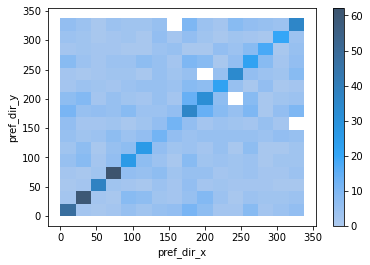

In [307]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [292]:
dangle = dsi_self.pref_dir_x - dsi_self.pref_dir_y
dsi_self['dpref_dir']=np.arctan2(np.sin(dangle), np.cos(dangle))

In [301]:
dsi_self['avg_DSI']=dsi_self.DSI_x/2 + dsi_self.DSI_y/2
dsi_self['avg_act']=dsi_self.Act_Pref_Dir_x/2 + dsi_self.Act_Pref_Dir_y/2

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_DSI'>

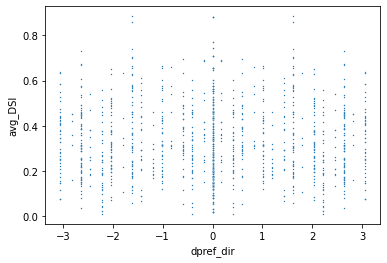

In [299]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_DSI',
                dsdata=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

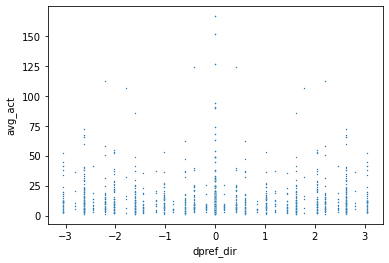

In [302]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act',
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='dpref_dir', ylabel='avg_act'>

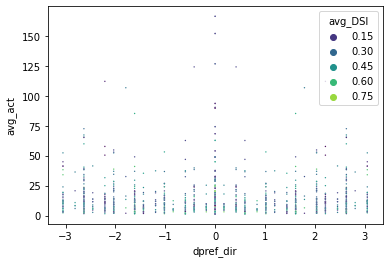

In [304]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='avg_act', 
                hue='avg_DSI',palette=plt.cm.viridis, 
                data=dsi_self, s=2,ax=ax)

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

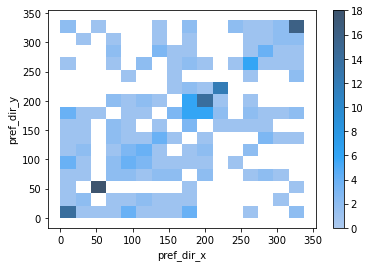

In [310]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self.query('avg_act>20'), x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [ ]:
f, ax = plt.subplots()
sns.scatterplot(x='dpref_dir', y='OSI_x', data=dsi_self, s=2,ax=ax)

In [276]:
dsi_self.pref_dir_x.value_counts().shape

(16,)

In [250]:
dsi_osi_df.shape, dsi_self.shape

((8944, 32), (10414, 63))

In [259]:
dsi_self.drop_duplicates(subset=['id_x', 'id_y'], keep=False).shape

(10414, 63)

In [254]:
dsi_self.shape

(10414, 63)

In [252]:
dsi_self.shape

(10414, 63)

In [243]:
dsi_osi_df.query(f'pt_root_id=={root_id}')[['scan_idx', 'session','unit_id','pt_root_id', 'DSI','OSI', 'pref_dir', 'pref_or']]

,scan_idx,session,unit_id,pt_root_id,DSI,OSI,pref_dir,pref_or
115,7,4,5564,864691135718541617,0.566859,0.174294,0.0,135.0
1864,5,8,8350,864691135718541617,0.640613,0.491521,157.5,157.5


In [150]:
root_id

864691135753932237

In [151]:
syn_df = client.materialize.synapse_query(pre_ids=root_id,
                                          split_positions=True,
                                          desired_resolution=[1000,1000,1000])

In [152]:
syn_dfm=pd.merge(syn_df, nuc_df, left_on='post_pt_root_id', right_on='pt_root_id', how='inner')

In [153]:
delt_v=syn_dfm[['ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z']].values-syn_dfm[['pt_position_x', 'pt_position_y', 'pt_position_z']].values

In [154]:
syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']]=delt_v

In [155]:
syn_dfm['soma_to_syn_r']=np.linalg.norm(syn_dfm[['soma_to_syn_x', 'soma_to_syn_y', 'soma_to_syn_z']], axis=1)

In [156]:
syn_dfm['theta']=np.arctan2(syn_dfm.soma_to_syn_x, syn_dfm.soma_to_syn_z)

In [157]:
syn_dfm=syn_dfm.drop_duplicates(subset='id_x')

In [180]:
syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id')

,id_x,valid_x,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,...,292.5,315.0,337.5,null_dir,DSI,Act_Pref_Dir,OSI,Act_Pref_Or,pref_or,null_or
0,133954227,t,642.320,683.584,910.68,86849806009668531,864691135753932237,642.400,683.952,910.80,...,10.911670,8.378872,7.886239,22.5,0.623543,17.120943,0.292127,12.775335,45.0,135.0
1,96423091,t,559.232,633.400,758.36,83962969041459235,864691135753932237,559.272,633.480,758.24,...,10.382027,15.945401,14.627197,90.0,0.273815,36.483517,0.439726,28.641140,90.0,0.0
2,108300450,t,600.680,760.912,696.88,85445041794907457,864691135753932237,600.504,761.152,696.68,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
3,126226046,t,634.608,687.112,774.08,86568468002376450,864691135753932237,634.520,686.696,774.28,...,4.090281,3.615450,5.830765,315.0,0.300496,6.721735,0.487695,5.615542,90.0,0.0
4,185393273,t,777.328,667.664,1001.04,91493593638252359,864691135753932237,776.968,668.088,1001.04,...,4.277564,7.762255,6.088434,225.0,0.356171,25.277296,0.496858,18.638725,45.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,182525672,t,755.176,691.992,692.56,90720361079354402,864691135753932237,755.056,692.504,692.72,...,6.535955,19.199238,17.229132,337.5,0.163868,23.982376,0.217886,20.605755,157.5,67.5
136,171726958,t,736.128,696.552,701.08,90087179887496251,864691135753932237,735.792,696.632,701.04,...,3.685940,6.876083,3.689906,135.0,0.136044,6.876083,0.304835,6.224863,22.5,112.5
137,255144807,t,937.856,688.528,748.88,96983042073419955,864691135753932237,937.352,688.712,748.88,...,19.621037,20.112415,28.113522,45.0,0.208059,37.840328,0.230838,31.323238,45.0,135.0
138,125652888,t,623.216,744.896,714.44,86218548225528708,864691135753932237,623.048,745.072,714.56,...,0.933556,1.406676,2.144675,180.0,0.324549,3.715112,0.494895,2.954076,22.5,112.5


(-150.0, 150.0)

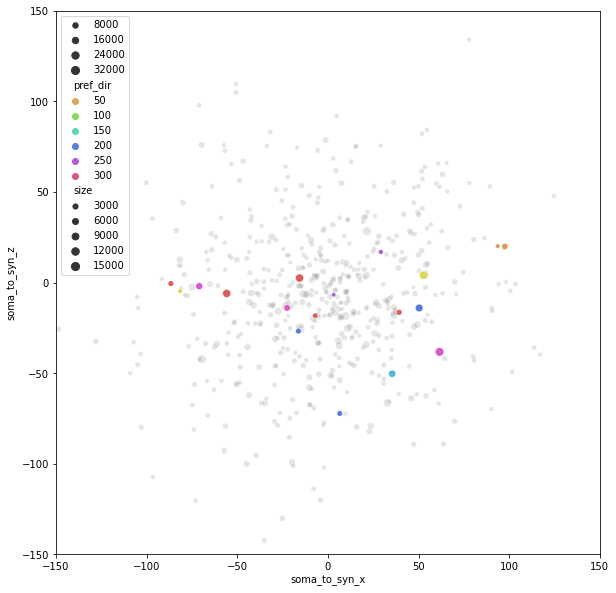

In [215]:
f, ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z',c=[[.5,.5,.5]],
                data=syn_dfm, size='size',alpha=.2,ax=ax)
sns.scatterplot(x='soma_to_syn_x', y='soma_to_syn_z', hue='pref_dir',size='size', palette='hls',vmax=360,vmin=0,
                data=syn_dfm.merge(dsi_osi_df, left_on='post_pt_root_id', right_on='pt_root_id').query('DSI>.5').query('Act_Pref_Dir>10'), ax=ax)
ax.set_aspect('equal')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)


In [311]:
tun_orac=pd.read_feather('tuning_curve_oracle.feather')

In [320]:
tun_orac

,animal_id,scan_session,scan_idx,unit_id,direction,response_mean,osi,dsi,pref_dir,pref_ori,oracle
0,17797,4,7,1,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.866137, 0.917347, 0.949379, 0.865518, 0.704...",0.130614,0.081838,0.500663,0.500663,0.078895
1,17797,4,7,3,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.36077, 1.39851, 1.99043, 3.18652, 4.58155, ...",0.284172,0.060989,1.781440,1.781440,0.200469
2,17797,4,7,4,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.21418, 1.21815, 0.860304, 0.420344, 0.20278...",0.432913,0.101887,3.406990,0.265397,0.042252
3,17797,4,7,5,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.537714, 0.46008, 0.39988, 0.329272, 0.30109...",0.077473,0.151048,5.054350,1.912757,0.473355
4,17797,4,7,6,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.34916, 1.36445, 1.29873, 0.803745, 0.690824...",0.171036,0.067236,6.174000,3.032407,0.169292
...,...,...,...,...,...,...,...,...,...,...,...
115367,17797,9,6,5494,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.880217, 1.01791, 0.938047, 0.920616, 0.6407...",0.206578,0.107160,3.995770,0.854177,0.179751
115368,17797,9,6,5495,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.04271, 1.19028, 1.43485, 1.86599, 1.85754, ...",0.124026,0.110393,1.331250,1.331250,0.054913
115369,17797,9,6,5496,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[0.338954, 0.337982, 0.527279, 0.922358, 1.852...",0.408453,0.123545,1.804710,1.804710,0.042267
115370,17797,9,6,5497,"[0.0, 0.3839724354387525, 0.7853981633974483, ...","[1.52055, 1.37349, 0.982758, 0.937725, 0.91138...",0.147547,0.051513,0.039345,0.039345,0.115852


In [324]:
coreg_merge=pd.merge(coreg_df, tun_orac,
         right_on=['scan_session', 'scan_idx', 'unit_id'], left_on=['session', 'scan_idx', 'unit_id'])

In [328]:
dsi_self2 = pd.merge(coreg_merge, coreg_merge, on='pt_root_id', how='inner')
dsi_self2=dsi_self2[dsi_self2.id_x!=dsi_self2.id_y]

<AxesSubplot:xlabel='pref_dir_x', ylabel='pref_dir_y'>

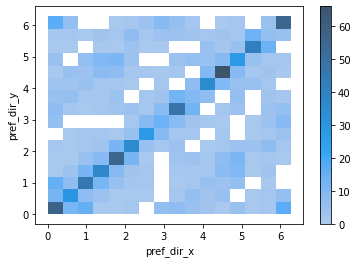

In [329]:
f, ax = plt.subplots()
sns.histplot(data=dsi_self2, x='pref_dir_x', y='pref_dir_y',bins=16, ax=ax, cbar=True)


In [332]:
dsi_self2.shape

(1470, 33)

In [339]:
dsi_self2[['session_x', 'scan_idx_x', 'unit_id_x']].value_counts()

session_x  scan_idx_x  unit_id_x
6          2           6616         24
           6           6252         18
7          4           5567         12
6          2           1808         12
7          5           6655         12
                                    ..
6          4           4933          1
                       4996          1
                       5007          1
                       5084          1
           7           4077          1
Length: 948, dtype: int64